# Univariate Time Series Forecasting

## Install fbprophet for our forecasting

In [ ]:
# Install fbprophet as it's not there by default on Colab instances

pip install fbprophet

## Import fbprophet, datetime, pandas, timeseriessplit, numpy

In [68]:
# import the required packages and libraries

import numpy as np
import pandas as pd
import fbprophet
from plotnine import * 
from sklearn.model_selection import TimeSeriesSplit 
from fbprophet import Prophet 
from datetime import datetime
from pandas import read_csv

## Mount our Google drive

In [69]:
# import our google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load our datasets from our Google Drive, and take a look at the shapes

We had created a nice clean dataset in the previous assignment so we were able to simply now import this for the forecasting stage

In [70]:
# load data
X = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features.csv')
Y = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_labels.csv')
# summarize shape
print(X.shape)
print(Y.shape)
# show first few rows
print(X.head())
print(Y.head())

(26417, 271)
(26417, 3)
   Unnamed: 0  ...  value__permutation_entropy__dimension_4__tau_1
0       46343  ...                                            -0.0
1       46343  ...                                            -0.0
2       46343  ...                                            -0.0
3       46343  ...                                            -0.0
4       46343  ...                                            -0.0

[5 rows x 271 columns]
      id  time  1
0  46343   390  0
1  46343   420  0
2  46343   450  0
3  46343   480  0
4  46343   510  0


## Join our sleep stage label data back to the extracted features data

For the purposes of this assignment we wanted to rejoin our extracted features data with the true sleep stage labels

In [71]:
full_df = pd.concat([Y[["time", "1"]], X[X.columns[2:]]], axis=1)
print(full_df.shape)

(26417, 271)


We aksi wanted to add our subject IDs back in

In [72]:
# add subject id back in
full_df = pd.concat([Y[["time", "1", "id"]], X[X.columns[2:]]], axis=1)

## Convert our time column into the format that fbProphet needs

fbProphet needs the data to be in a precise format, with a 'ds' column for datetime and a 'y' column for the target column

In [73]:
# convert time column into fbProphet-friendly datetime format
full_df = full_df.rename(columns={"time": "ds", "1": "y"})
full_df["ds"] = full_df['ds'] = pd.to_datetime(full_df['ds'], unit='s')

## Create a dictionary of each sleep subjects' seperate dataframes 

In [74]:
# creates a dictionary of each sleep subject's dataframe

dfs = dict(tuple(full_df.groupby('id')))

## Get us the list of unique subject IDs

In [75]:
# gets us the list of unique subject IDs

id_list = list(full_df['id'])
id_set = set(id_list)
id_list = list(id_set)

## Split into 5 time series

In [76]:
# sets the amount of splits we want per dataframe

tscv = TimeSeriesSplit(n_splits=5)

## Function for splitting our dataframe, building the model, and forecasting

In [77]:
def pro_ds_data_gen(df,tscv,daily_seasonality=True,weekly_seasonality=False,yearly_seasonality=False):
    out_df=pd.DataFrame()
    for i,(train_i,test_i) in enumerate(tscv.split(df)): #For Time Series Split
        #Use indexes to grab the correct data for this split
        train_df=df.copy().iloc[train_i,:]
        test_df=df.copy().iloc[test_i,:]
        #Build our model using prophet and make predictions on the test set
        model=Prophet(
            daily_seasonality=daily_seasonality,
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality
        )
        model.fit(train_df)
        predictions=model.predict(test_df)

        #Combine predictions and training into one df for plotting
        pred_df=predictions.loc[:,["ds","yhat"]]
        pred_df["y"]=test_df.y.tolist()
        train_df["train"]="Train"
        pred_df["train"]="Test"
        sub_df=train_df.append(pred_df).reset_index(drop=True)
        sub_df["split"]="Split "+str(i+1)
        sub_df["rmse"]=(np.mean((sub_df.yhat-sub_df.y)**2))**.5 #calculating rmse for the split
        out_df=out_df.append(sub_df).reset_index(drop=True)
    return out_df

## Our first subject

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



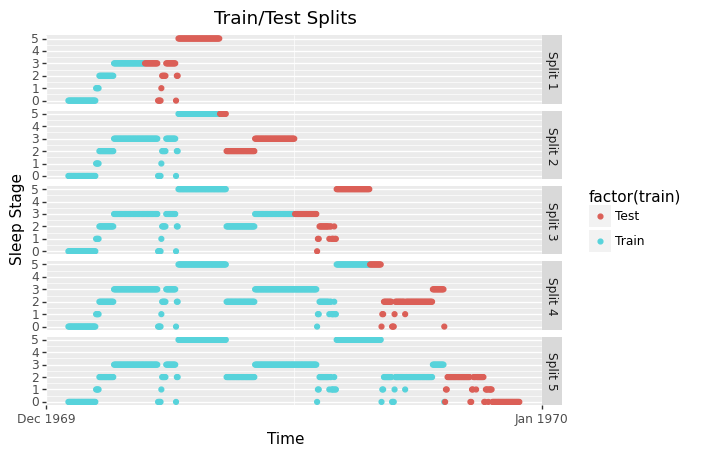

<ggplot: (8729629998898)>

In [132]:
# Subject 46343 was chosen as the subject to try out first 

dfs[46343] = dfs[46343][['ds','y']]
year_weak_seas_df=pro_ds_data_gen(dfs[46343],tscv, True, False, False)

(ggplot(year_weak_seas_df,aes("ds","y",color="factor(train)"))+\
 geom_point()+facet_grid('split~.'))+\
labs(title="Train/Test Splits",x="Time",y="Sleep Stage")+\
scale_x_date(date_breaks="6 months",date_labels =  "%b %Y")

We can see above that this subject looks to have a pretty standard sleep cycle for the night in question. They start from awake and gradually move through the sleep stages before returning to awake at the end

We now wanted to see what the root mean square error was from our prediction and we can see below that it's very high at over 5

In [133]:
# gets us the root mean squared error between the actual y values and the predicted y values in our test splits
from sklearn.metrics import mean_squared_error
rmse_df = year_weak_seas_df[year_weak_seas_df['train'] == "Test"]
rms = mean_squared_error(rmse_df['y'], rmse_df['yhat'], squared=False)
print(rms)





5.873423473140108


This can be fixed somewhat by restricting the prefictions to the true range of the sleep stages, [0-5] and also ensuring that any floating point numbers were converted to the appropriate category, eg. (3.2 -> 3, 4.7 -> 5) 

In [134]:
# loops through our training/test splits and creates a single yhat column for plotting purposes
# also ensures that any sleep stage predictions that have gone above 5 are set back to 5 and any that have gone below 0 are set back to 0, keeping us in our 0-5 range for the cycle
for i in range(0,len(year_weak_seas_df)):
  if pd.isnull(year_weak_seas_df.iloc[i,3]):
    year_weak_seas_df.iloc[i,3] = year_weak_seas_df.iloc[i,1]
  if float(year_weak_seas_df.iloc[i,3]) > 5:
    year_weak_seas_df.iloc[i,3] = 5
  elif float(year_weak_seas_df.iloc[i,3]) < 0:
    year_weak_seas_df.iloc[i,3] = 0
year_weak_seas_df["yhat"] = year_weak_seas_df["yhat"].astype(int)
year_weak_seas_df["yhat"] = year_weak_seas_df["yhat"].astype(str)

Checking again

In [135]:
# gets us the root mean squared error between the actual y values and the predicted y values in our test splits
from sklearn.metrics import mean_squared_error
rmse_df = year_weak_seas_df[year_weak_seas_df['train'] == "Test"]
rms = mean_squared_error(rmse_df['y'], rmse_df['yhat'], squared=False)
print(rms)


3.018061571965342


We can see it has improved although still isn't very good. If we take a look at the below, the real splits followed by the predicted splits, we can get a feel for where things are going badly

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



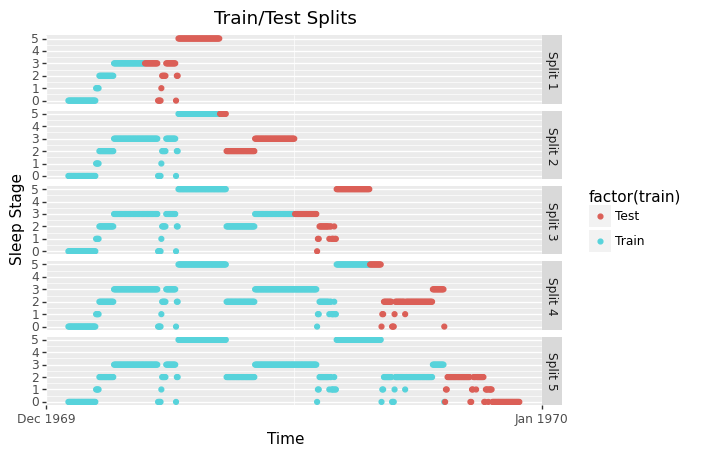

<ggplot: (8729645448014)>

In [87]:
# plot the true splits once more, as above

(ggplot(year_weak_seas_df,aes("ds","y",color="factor(train)"))+\
 geom_point()+facet_grid('split~.'))+\
labs(title="Train/Test Splits",x="Time",y="Sleep Stage")+\
scale_x_date(date_breaks="6 months",date_labels =  "%b %Y")


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



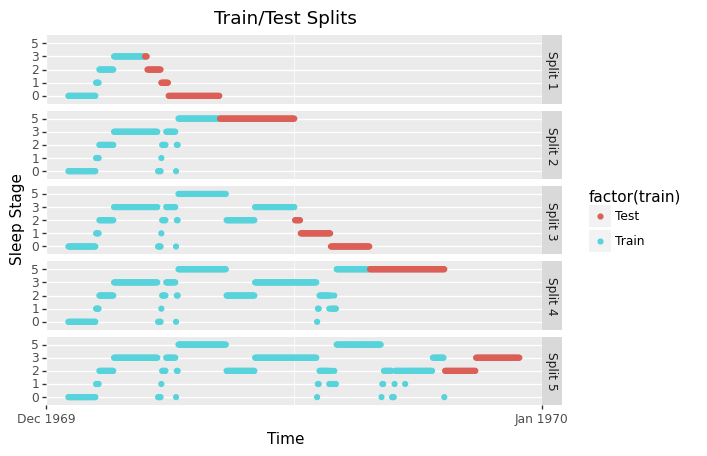

<ggplot: (8729629855524)>

In [86]:
# plot the predicted splits

(ggplot(year_weak_seas_df,aes("ds","yhat",color="factor(train)"))+\
 geom_point()+facet_grid('split~.'))+\
labs(title="Train/Test Splits",x="Time",y="Sleep Stage")+\
scale_x_date(date_breaks="6 months",date_labels =  "%b %Y")

## Thoughts after this step. and where to next

It's clear from the above that all our model is doing is continuing the previous trend for each split. Our model knows nothing about how the "sleep cycle" is likely to play out and so it continues to increase or decrease the sleep stage number based purely on whether it had mvoed up or down recently. And so if we carry our prediction on long enough, the subject will either be perpetually in Sleep stage 5, or sleep stage 0 (awake) depending on whether the stage had recently increased or decreased. This really isn't that useful at all. This makes sense when we think about how the dataset is somewhat flawed for the task that we have. We only have one cycle per person and so if we split this cycle at all, there is no way to train our model to predict what will happen in the remainig sleep cycle.

At this stage we decided that we needed to move on from this approach so as not to waste any more time. We needed to rethink the data, and make some assumptions and changes that will allow for some meaningful forecast modelling. 

We decided that next we should retry this Univariate approach but instead of taking each of the 31 individual subjects as being unique, we could instead pretend that the first 30 individuals sleep cycles were in fact 30 previous nights of our 31st subject. Giving us a lot of sleep data for a single theoritical person, and something far more meaningful to try train our forecasting model on. 

# Univariate Assuming Data All Belongs To One Subject

## Create one large dataframe for our theoretical subject

In [ ]:
# this will incrementally add one day to the datetime for each subject, essentially creating a 31 day range instead of the same date per subject

i = 1
for subject, df in dfs.items():
  dfs[subject] = dfs[subject][['ds','y']]
  dfs[subject]['ds'] = df['ds'].apply(lambda dt: dt.replace(day=i))
  i = i + 1

In [93]:
joined_df = pd.DataFrame()

This will add the first 30 subjects to a single data frame, and add our final subject to their own dataframe

In [94]:
i = 1
for subject, df in dfs.items():
  if i < len(dfs):
    joined_df = pd.concat([joined_df, df], ignore_index=True)
  else:
    test_df = df
  i = i + 1

In [98]:
joined_df

,ds,y
0,1970-01-01 00:06:30,0
1,1970-01-01 00:07:00,0
2,1970-01-01 00:07:30,0
3,1970-01-01 00:08:00,0
4,1970-01-01 00:08:30,0
...,...,...
26052,1970-01-31 02:57:30,2
26053,1970-01-31 02:58:00,2
26054,1970-01-31 02:58:30,2
26055,1970-01-31 02:59:00,2


This will take half of the final subject's data and add it back to the large training dataframe, theoritcally helping our forecast 

In [96]:
i = 0
for row in test_df:
  while i < len(test_df)/2:
    joined_df = joined_df.append(test_df.iloc[i])
    i = i + 1




In [97]:
test_df = test_df.iloc[int(len(test_df)/2):]

Ensure the datetime column is actually in datetime format for compatibility

In [ ]:
test_df.ds = pd.to_datetime(test_df.ds)

Building and fitting our model

In [100]:
from fbprophet import Prophet
model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False)

In [101]:
model.fit(joined_df)

Making our forecasting dataframe

In [102]:
forecast = model.predict(test_df)

Resetting the indexes and joining the test dataframe with the forecasting dataframe

In [139]:
joined_forecast = pd.DataFrame()
joined_forecast = pd.concat([test_df[['ds','y']].reset_index(), forecast[['yhat']].reset_index()], axis=1)

Let's take a look at what we are left with, we can see it has exactly what we want for analysis, the timestamps 

In [140]:
joined_forecast

,index,ds,y,index,yhat
0,26057,1970-01-31 03:00:00,2,0,2.293918
1,26058,1970-01-31 03:00:30,2,1,2.293913
2,26059,1970-01-31 03:01:00,2,2,2.293928
3,26060,1970-01-31 03:01:30,2,3,2.293962
4,26061,1970-01-31 03:02:00,2,4,2.294014
...,...,...,...,...,...
355,26412,1970-01-31 05:57:30,0,355,2.464653
356,26413,1970-01-31 05:58:00,0,356,2.465585
357,26414,1970-01-31 05:58:30,0,357,2.466533
358,26415,1970-01-31 05:59:00,0,358,2.467496


Once more fixing the predictions by restricting them to the true range of the sleep stages, [0-5] and also ensuring that any floating point numbers were converted to the appropriate category, eg. (3.2 -> 3, 4.7 -> 5)

In [110]:
for i in range(0,len(joined_forecast)):
  joined_forecast.iloc[i,4] = round(float(joined_forecast.iloc[i,4]))
  
  if float(joined_forecast.iloc[i,4]) > 5:
    joined_forecast.iloc[i,4] = 5
  elif float(joined_forecast.iloc[i,4]) < 0:
    joined_forecast.iloc[i,4] = 0

joined_forecast["yhat"] = joined_forecast["yhat"].astype(int)
joined_forecast["yhat"] = joined_forecast["yhat"].astype(str)

In [111]:
joined_forecast

,index,ds,y,index,yhat
0,26057,1970-01-31 03:00:00,2,0,2
1,26058,1970-01-31 03:00:30,2,1,2
2,26059,1970-01-31 03:01:00,2,2,2
3,26060,1970-01-31 03:01:30,2,3,2
4,26061,1970-01-31 03:02:00,2,4,2
...,...,...,...,...,...
355,26412,1970-01-31 05:57:30,0,355,2
356,26413,1970-01-31 05:58:00,0,356,2
357,26414,1970-01-31 05:58:30,0,357,2
358,26415,1970-01-31 05:59:00,0,358,2


In [141]:
from sklearn.metrics import mean_squared_error
rmse_df = joined_forecast
rms = mean_squared_error(rmse_df['y'], rmse_df['yhat'], squared=False)
print(rms)

1.6884144391587432


This managed to improve our error significantly, roughly by half. We knew we could make some adjustments and try ti improve on this for univariate but with the signifcantly shorter deadline for this assignemnt and being a duo group we decided it was time to start using all of the lovely features that we had extracted in the previous assignment to see what improvements that might bring. The next section will discuss Multivariate Time Series Forecasting